In [8]:
"""
trying to run bandits and see the performance of the estimator.

"""

using Infiltrator
using ProgressMeter
using Plots
plotly()

include("./KjBandits.jl")
include("./KjFunctions.jl")


algo_factory (generic function with 1 method)

### All-best

In [16]:
opt = (
    σ² = (1.0/2)^2, 
    dataseed=313, #123
    algoseed=789,
    n_trials = 200, #50, #1000, #200
    N_ary = [100, 1000, 2000, 4000, 6000, 8000, 10000], 
    K = 1024, # 3:8, 3:10
    algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
    problem_name = "linear_K_one_odd", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
    
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["naiveoracle", "haver", "avg", "max", "weightedms_4", ]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.N_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_N in eachindex(opt.N_ary)
        global problem, algo
        N = opt.N_ary[i_N]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=opt.K, alpha=NaN, Delta=NaN)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        for i in 1:opt.K
            algo.n_pulls[i] = N
            rewards = problem.μ[i] .+ sqrt(problem.σ²)*randn(problem.rngs[i], N) 
            algo.sum_rewards[i] = sum(rewards) 
        end 
        
        for i_est in eachindex(estimators)
            hatvalues[i_try, i_N, i_est] = estimate_value(estimators[i_est], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["naiveoracle", "haver", "avg", "max", "weightedms_4"]
opt = (σ² = 0.25, dataseed = 313, algoseed = 789, n_trials = 200, N_ary = [100, 1000, 2000, 4000, 6000, 8000, 10000], K = 1024, algo_name = "uniform", problem_name = "linear_K_one_odd")


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


7×5 Matrix{Float64}:
 0.0380037   0.0906723  0.504397  0.0949016   0.0476851
 0.0121394   0.032946   0.504405  0.0219948   0.0119267
 0.00863288  0.0235035  0.504372  0.0145322   0.00853057
 0.00615207  0.0173064  0.504379  0.00891176  0.00541098
 0.00449979  0.0144254  0.504387  0.00664346  0.00437615
 0.00401378  0.0126996  0.50439   0.00541682  0.00358046
 0.00354428  0.0114888  0.504399  0.00443241  0.00296733

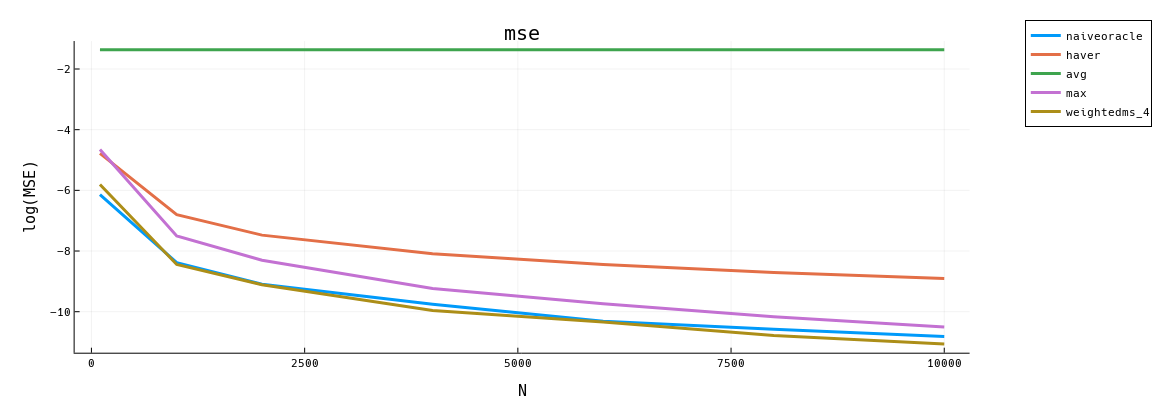

In [17]:
x = opt.N_ary
i = 1; plot(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
# i = 6; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="N", ylabel="log(MSE)", legend=:outertopright)  
title!("mse")

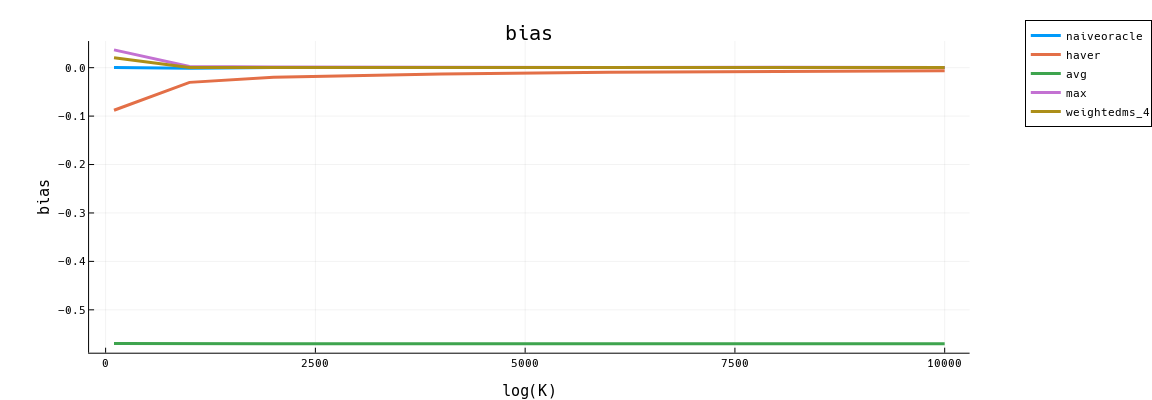

In [11]:
x = opt.N_ary
i = 1; plot(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
# i = 6; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:outertopright)  
title!("bias")